In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt

from skaro.analysis import count_planets
from skaro.model import Model
from skaro.utilities.dataframe import rename_labels
from skaro.utilities.math import calculate_pca
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting sim_id to 09_18.



yt : [INFO     ] 2024-02-08 13:39:00,266 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2024-02-08 13:39:00,439 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2024-02-08 13:39:00,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-02-08 13:39:00,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-02-08 13:39:00,440 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2024-02-08 13:39:00,441 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-02-08 13:39:00,442 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2024-02-08 13:39:00,442 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2024-02-08 13:39:00,443 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2024-02-08 13:39:00,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-02-08 13:39:00,444 Parameters: hubble_constant   

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Metallicity_model_effects"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()

## EFFECTS OF METALLICITY MODEL ON PLANET TYPES

In [12]:
no_metallicity_cut = count_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    normalize_by="planet_hosting_number",
    model_config={"ngpps_hard_bounds": "none"},
    long_format=True,
    value_name="Occurrence Rate",
    description={"Metallicity Model": "Without [Fe/H] Cut"},
)
metallicity_cut = count_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    normalize_by="planet_hosting_number",
    model_config={"ngpps_hard_bounds": "lower"},
    long_format=True,
    value_name="Occurrence Rate",
    description={"Metallicity Model": "With [Fe/H] Cut"},
)

# combine dataframes
occurrence_rate_combined = pd.concat(
    [no_metallicity_cut, metallicity_cut], ignore_index=True
)


      CONFIG: Setting ngpps_hard_bounds to none.


      TIMER: Block 'Adding Planets...' took 1.71 seconds.


      CONFIG: Setting ngpps_hard_bounds to lower.


      TIMER: Block 'Adding Planets...' took 1.62 seconds.



In [13]:
relative_occurence_rate = pd.merge(
    metallicity_cut.drop(columns=["Metallicity Model"]),
    no_metallicity_cut.drop(columns=["Metallicity Model"]),
    on=["Planet Type", "Component"],
    suffixes=(" with Cut", " without Cut"),
)
relative_occurence_rate["Occurrence Rate Ratio"] = (
    relative_occurence_rate["Occurrence Rate with Cut"]
    / relative_occurence_rate["Occurrence Rate without Cut"]
)

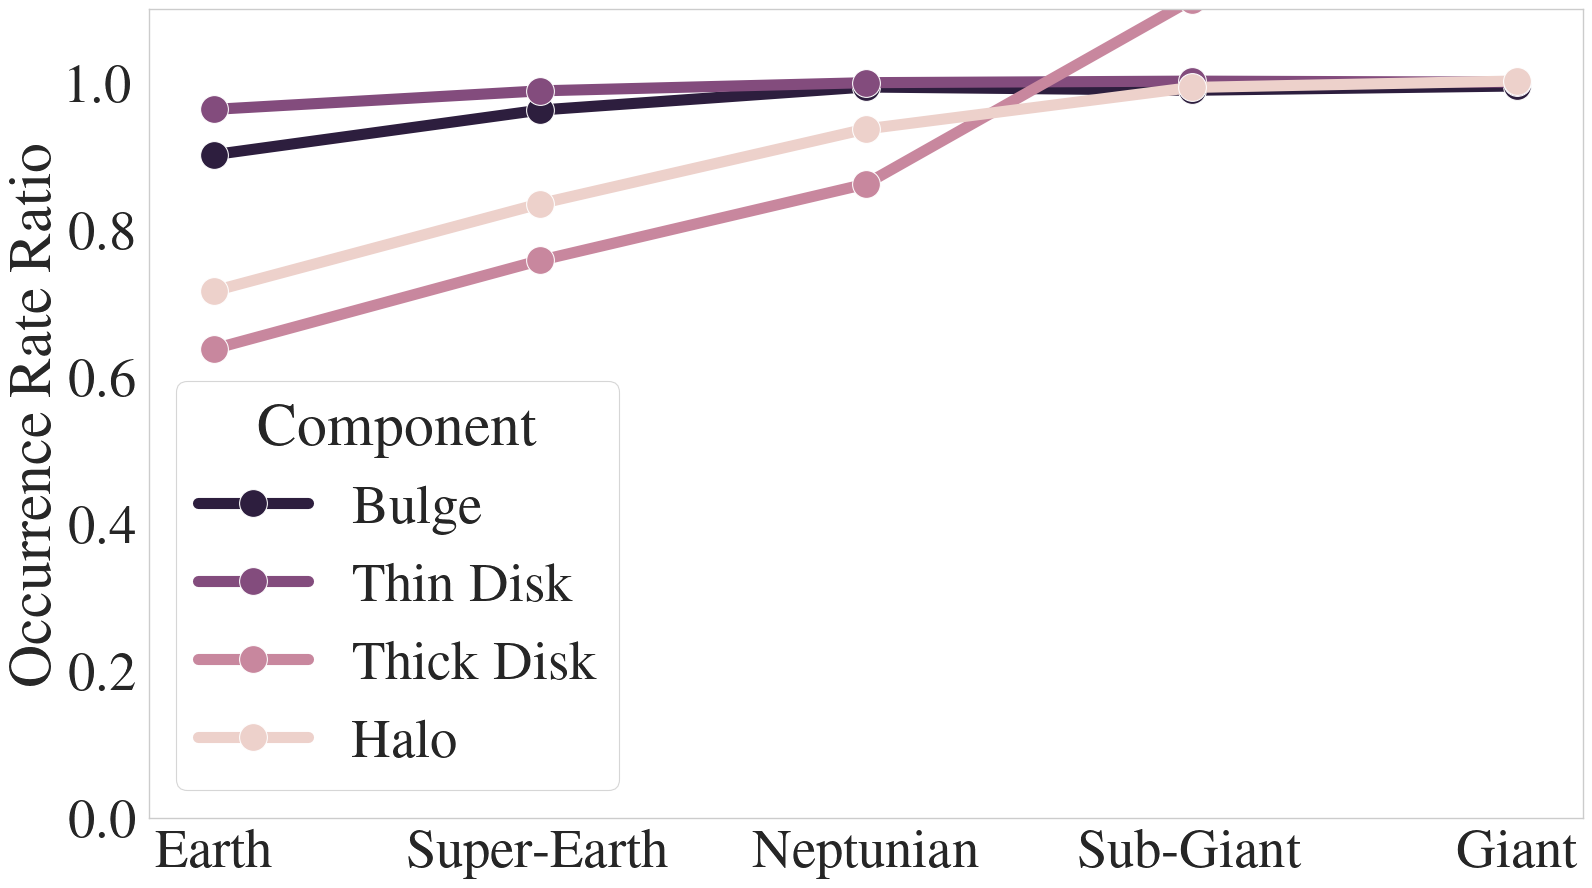

In [16]:
relative_occurence_rate_lineplot = sns.lineplot(
    data=relative_occurence_rate,
    x="Planet Type",
    y="Occurrence Rate Ratio",
    hue="Component",
    hue_order=["Bulge", "Thin Disk", "Thick Disk", "Halo"],
    marker="o",
    palette=get_palette(4, reverse=True),
    linewidth=8,
    markersize=20,
)

# adjust the line width for the legend
for line in relative_occurence_rate_lineplot.legend().get_lines():
    line.set_linewidth(8)
relative_occurence_rate_lineplot.legend(title="Component")

relative_occurence_rate_lineplot.set_ylim(0, 1.1)
relative_occurence_rate_lineplot.set_xlabel("")

FigureProcessor(relative_occurence_rate_lineplot.figure).save(
    f"metallicity_effect.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)